<a href="https://colab.research.google.com/github/YTIputi/Classification/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classification**

## **Libraries**

In [14]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from PIL import Image
from tqdm import tqdm
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import random_split

from torchvision.datasets import ImageFolder
import torchvision.transforms.v2 as tfs

---

## **Dataset**

**About Dataset**

Hello everyone!

This is the dataset I have used for my matriculation thesis.

It contains about 28K medium quality animal images belonging to 10 categories: dog, cat, horse, spyder, butterfly, chicken, sheep, cow, squirrel, elephant.

I have used it to test different image recognition networks: from homemade CNNs (~80% accuracy) to Google Inception (98%). It could simulate a smart gallery for a researcher (like a biologist).

All the images have been collected from "google images" and have been checked by human. There is some erroneous data to simulate real conditions (eg. images taken by users of your app).

The main directory is divided into folders, one for each category. Image count for each category varies from 2K to 5 K units.

In [2]:
path = kagglehub.dataset_download("alessiocorrado99/animals10")
os.listdir(path)

100%|██████████| 586M/586M [00:07<00:00, 79.7MB/s]

Extracting files...


['raw-img', 'translate.py']

In [3]:
dataset = ImageFolder(os.path.join(path, 'raw-img'))

---

## **EDA**

**Class distribution**

In [4]:
counts = Counter([label for _, label in dataset.samples])
counts

Counter({0: 4863,
         1: 2623,
         2: 1446,
         3: 2112,
         4: 3098,
         5: 1668,
         6: 1866,
         7: 1820,
         8: 4821,
         9: 1862})

In [5]:
weights = [len(dataset) / counts[i] for i in range(len(counts))]
weights = torch.tensor(weights, dtype=torch.float32)
weights

tensor([ 5.3833,  9.9806, 18.1044, 12.3954,  8.4503, 15.6948, 14.0295, 14.3841,
         5.4302, 14.0596])

**Visual preview of examples**

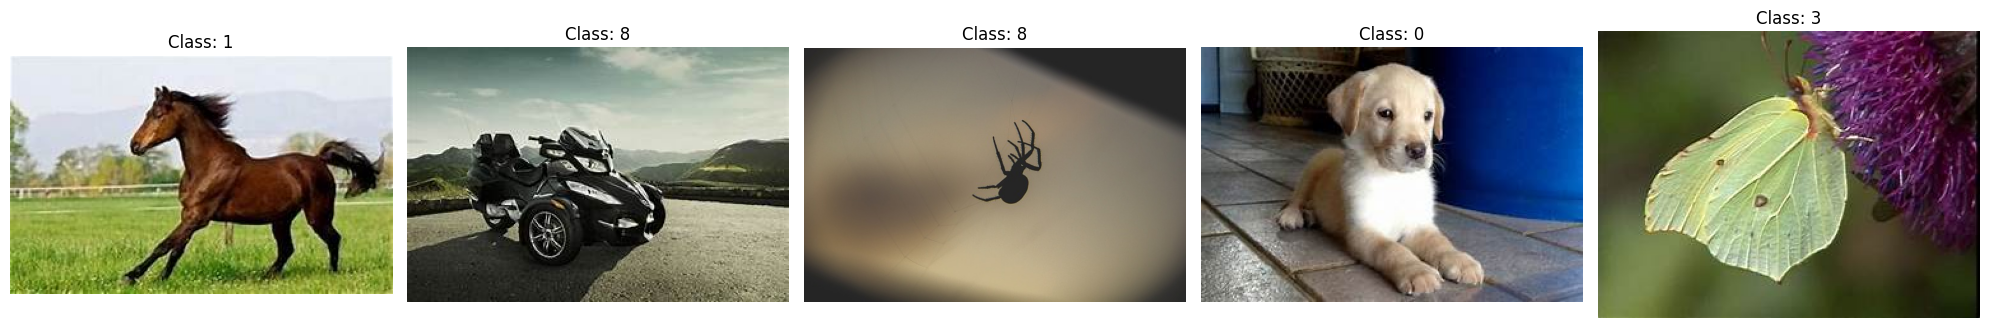

In [6]:
N, n = 5, len(dataset)
fig, axe = plt.subplots(1, N, figsize=(20, 7))
for i in range(N):
  index = np.random.choice(n)
  axe[i].imshow(dataset[index][0])
  axe[i].axis('off')
  axe[i].set_title(f'Class: {dataset[index][1]}')

plt.tight_layout()
plt.show()

**Image sizes and proportions**

In [7]:
sizes = {'w': [], 'h': []}
for path, _ in tqdm(dataset.samples):
  with Image.open(path) as img:
    w, h = img.size
    sizes['w'].append(w)
    sizes['h'].append(h)

  5%|▍         | 1243/26179 [00:06<02:14, 185.64it/s]


KeyboardInterrupt: 

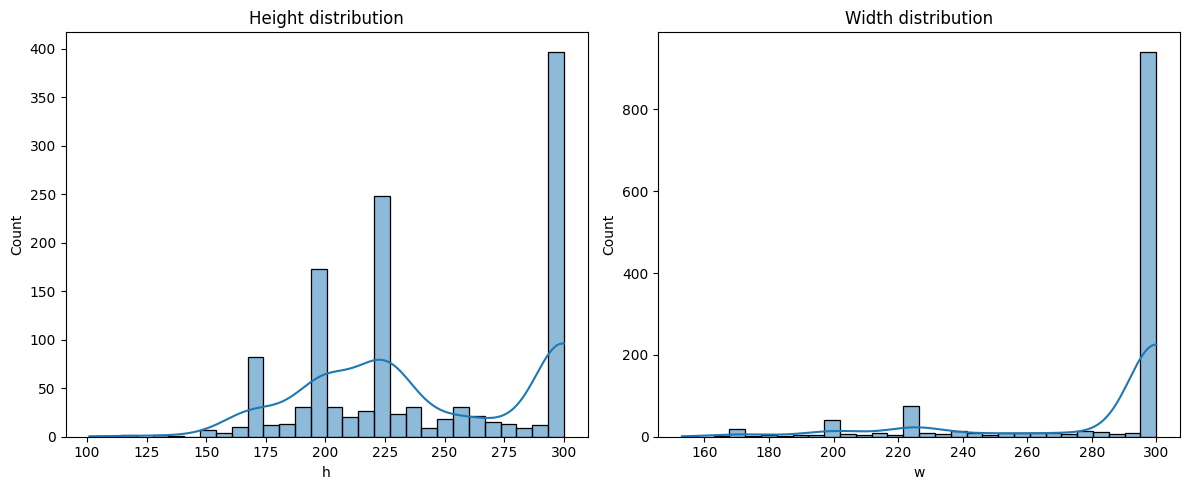

In [8]:
df = pd.DataFrame(sizes)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['h'], bins=30, kde=True)
plt.title('Height distribution')

plt.subplot(1, 2, 2)
sns.histplot(df['w'], bins=30, kde=True)
plt.title('Width distribution')

plt.tight_layout()
plt.show()


In [ ]:
df.describe()

,w,h
count,26179.000000,26179.000000
mean,320.038810,252.630162
std,196.935326,148.403298
min,60.000000,57.000000
25%,300.000000,200.000000
50%,300.000000,225.000000
75%,300.000000,300.000000
max,6720.000000,6000.000000


---

## **Model**

In [6]:
transform = tfs.Compose([tfs.ToImage(),
                         tfs.Resize(256),
                         tfs.CenterCrop(224),
                         tfs.Grayscale(num_output_channels=1),
                         tfs.ToDtype(torch.float32, scale=True)
])

In [7]:
new_dataset = ImageFolder(os.path.join(path, 'raw-img'), transform=transform)

train_size = int(0.8 * len(new_dataset))
test_size = len(new_dataset) - train_size

train_dataset, test_dataset = random_split(new_dataset, [train_size, test_size])

In [8]:
dataloader = data.DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)

In [9]:
class ClassificationAnimals(nn.Module):
  def __init__(self, num_classes):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.linear = nn.Linear(256, num_classes)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)

    x = F.relu(self.conv2(x))
    x = self.pool2(x)

    x = F.relu(self.conv3(x))
    x = self.pool3(x)

    x = F.relu(self.conv4(x))
    x = self.pool4(x)

    x = self.avgpool(x)
    x = x.view(x.size(0), -1)

    x = self.linear(x)
    return x

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ClassificationAnimals(len(counts)).to(device)
model

ClassificationAnimals(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (linear): Linear(in_features=256, out_features=10, bias=True)
)

In [37]:
weights = weights.to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(params=model.parameters(), lr=.001)

In [38]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    start_time = time.time()

    loop = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch_idx, (inputs, labels) in loop:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        avg_loss = running_loss / (batch_idx + 1)

        loop.set_postfix({
            'batch': f'{batch_idx + 1}/{len(dataloader)}',
            'avg_loss': f'{avg_loss:.4f}',
            'time/epoch(s)': f'{time.time() - start_time:.1f}'
        })

    print(f"Epoch {epoch+1} completed. Avg Loss: {avg_loss:.4f}, Time: {time.time() - start_time:.1f} sec\n")


Epoch 1/5:  75%|███████▌  | 1975/2618 [01:14<00:21, 30.22it/s, batch=1977/2618, avg_loss=0.7459, time/epoch(s)=75.0]

In [32]:
imgs = []
labels = []

for img, y in test_dataset:
    imgs.append(img)
    labels.append(y)

In [33]:
X_test = torch.stack(imgs).to(device)
y_test = torch.tensor(labels).to(device)
X_test.shape, y_test.shape

(torch.Size([5236, 1, 224, 224]), torch.Size([5236]))

In [40]:
batch_size = 16

model.eval()
all_preds = []

with torch.no_grad():
    for i in range(0, len(X_test), batch_size):
        batch = X_test[i:i+batch_size].to(device)
        outputs = model(batch)
        preds = torch.argmax(outputs, dim=1)
        all_preds.append(preds.cpu())

all_preds = torch.cat(all_preds)
print(all_preds)

tensor([7, 8, 8,  ..., 3, 0, 0])


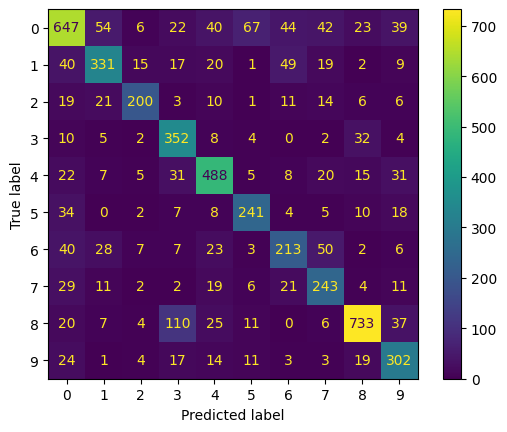

              precision    recall  f1-score   support

           0       0.73      0.66      0.69       984
           1       0.71      0.66      0.68       503
           2       0.81      0.69      0.74       291
           3       0.62      0.84      0.71       419
           4       0.75      0.77      0.76       632
           5       0.69      0.73      0.71       329
           6       0.60      0.56      0.58       379
           7       0.60      0.70      0.65       348
           8       0.87      0.77      0.81       953
           9       0.65      0.76      0.70       398

    accuracy                           0.72      5236
   macro avg       0.70      0.71      0.70      5236
weighted avg       0.72      0.72      0.72      5236



In [41]:
disp = ConfusionMatrixDisplay.from_predictions(y_test.cpu().numpy(), all_preds.cpu().numpy())
plt.show()

print(classification_report(y_test.cpu().numpy(), all_preds.cpu().numpy()))


---